# Model Evaluation for [retinanet_resnet50_fpn_v2](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.retinanet_resnet50_fpn_v2.html#retinanet-resnet50-fpn-v2)

In [23]:
from my_utils.dataset_loader import ObjectDetectionDataset, DatasetMode, simple_collate_fn
from torch.utils.data import DataLoader
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    average_precision_score, roc_auc_score,
    multilabel_confusion_matrix
)
import torchvision.ops as ops
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from torchvision.models.detection import RetinaNet_ResNet50_FPN_V2_Weights

warnings.filterwarnings("ignore")

In [24]:
data_dir = "D:\\Projects\\ml-ops-wildlife\\data\\WAID"

In [25]:
torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [26]:
test_dataset = ObjectDetectionDataset(data_dir, DatasetMode.TEST, transform=RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT.transforms())
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=simple_collate_fn)

Loading labels: 100%|██████████| 1437/1437 [00:00<00:00, 2801.03it/s]


In [27]:
model = torch.load("../models/retina.pt")
model.eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [28]:
test_image, test_class_ids, test_bboxes = test_dataset[125]

output = model(test_image.unsqueeze(0).to(device))

print(type(output[0]))
print(len(output[0]))
print(output[0])

<class 'dict'>
3
{'boxes': tensor([[391.2910,  76.0225, 442.9271, 115.7069],
        [293.1142, 162.1924, 336.8320, 181.8225],
        [103.2991, 591.1083, 140.6452, 624.3480],
        [276.5588, 552.9968, 340.3408, 596.8051],
        [593.6733, 157.9329, 640.0000, 188.9946],
        [459.6855,  65.7802, 496.7246,  84.8718],
        [326.3547, 429.8412, 384.6565, 450.1447],
        [396.8668, 244.1287, 454.2508, 264.1209],
        [576.1146, 312.6640, 622.3962, 361.4291],
        [601.1367, 346.7985, 640.0000, 379.7433],
        [403.9355, 243.0332, 448.0208, 257.5411],
        [532.2982, 526.9101, 585.9915, 564.5276],
        [579.1189, 212.1352, 621.2805, 252.5498],
        [334.7856, 428.6579, 375.3566, 443.2227],
        [397.4930,  71.8250, 437.8127, 103.3454],
        [272.6985, 553.2430, 334.2547, 596.3141],
        [262.5185, 554.1310, 308.7305, 594.4553],
        [491.3848, 192.3614, 517.8484, 213.3459],
        [471.0897,  96.9353, 514.2493, 120.7419],
        [382.3230,  81.

In [29]:
def compute_metrics(model, dataloader, conf_threshold=0.25):
    """
    Compute comprehensive metrics for YOLOv5 predictions using sklearn

    Returns:
        Dictionary containing various metrics and plots confusion matrices
    """
    model.eval()
    all_true_labels = []
    all_pred_labels = []
    all_pred_scores = []  # For AUC and mAP

    with torch.no_grad():
        for images, class_ids, bboxes in dataloader:
            images = images.to(device)
            batch_size = images.shape[0]

            # Get predictions
            pred = model(images)

            # Process each image in batch
            for idx in range(batch_size):
                # Prepare true labels
                single_true_labels = torch.zeros(6)  # 6 classes
                for true_class in class_ids[idx]:
                    single_true_labels[true_class] = 1

                # Get predictions for single image
                single_pred = pred[idx]

                # Get boxes, scores, and labels from prediction
                boxes = single_pred['boxes']
                scores = single_pred['scores']
                predicted_class_ids = single_pred['labels']

                # Filter by confidence threshold
                mask = scores > conf_threshold
                filtered_class_ids = predicted_class_ids[mask]
                filtered_scores = scores[mask]

                # Create one-hot encoded predictions
                num_classes = 6  # Assuming 6 classes
                pred_labels = torch.zeros(num_classes)

                # Mark predicted classes as 1
                for class_id in filtered_class_ids:
                    pred_labels[class_id - 1] = 1

                # Prepare class scores for mAP and AUC
                max_probs_per_class = torch.zeros(num_classes)
                for i in range(num_classes):
                    class_mask = filtered_class_ids == i
                    if class_mask.any():
                        max_probs_per_class[i] = filtered_scores[class_mask].max()

                # Append to overall lists
                all_true_labels.append(single_true_labels.cpu().numpy())
                all_pred_labels.append(pred_labels.cpu().numpy())
                all_pred_scores.append(max_probs_per_class.cpu().numpy())

    # Convert lists to arrays
    all_true_labels = np.array(all_true_labels)
    all_pred_labels = np.array(all_pred_labels)
    all_pred_scores = np.array(all_pred_scores)

    # Compute metrics
    metrics = {}

    # F1, Precision, Recall (per class and averaged)
    metrics['f1_per_class'] = f1_score(all_true_labels, all_pred_labels, average=None)
    metrics['precision_per_class'] = precision_score(all_true_labels, all_pred_labels, average=None)
    metrics['recall_per_class'] = recall_score(all_true_labels, all_pred_labels, average=None)

    metrics['f1_macro'] = f1_score(all_true_labels, all_pred_labels, average='macro')
    metrics['precision_macro'] = precision_score(all_true_labels, all_pred_labels, average='macro')
    metrics['recall_macro'] = recall_score(all_true_labels, all_pred_labels, average='macro')

    # mAP and AUC
    metrics['mAP_per_class'] = average_precision_score(all_true_labels, all_pred_scores, average=None)
    metrics['mAP'] = average_precision_score(all_true_labels, all_pred_scores, average='macro')

    # AUC might raise error if some classes don't have both positive and negative examples
    try:
        metrics['auc_per_class'] = roc_auc_score(all_true_labels, all_pred_scores, average=None)
        metrics['auc'] = roc_auc_score(all_true_labels, all_pred_scores, average='macro')
    except ValueError as e:
        print(f"Warning: Could not compute AUC: {e}")
        metrics['auc_per_class'] = np.array([np.nan] * all_true_labels.shape[1])
        metrics['auc'] = np.nan

    # Confusion Matrix
    metrics['confusion_matrices'] = multilabel_confusion_matrix(all_true_labels, all_pred_labels)

    # Print results
    print("\nPer-class metrics:")
    for i in range(all_true_labels.shape[1]):
        print(f"\nClass {i}:")
        print(f"F1: {metrics['f1_per_class'][i]:.4f}")
        print(f"Precision: {metrics['precision_per_class'][i]:.4f}")
        print(f"Recall: {metrics['recall_per_class'][i]:.4f}")
        print(f"mAP: {metrics['mAP_per_class'][i]:.4f}")
        print(f"AUC: {metrics['auc_per_class'][i]:.4f}")

    print("\nOverall metrics:")
    print(f"Macro F1: {metrics['f1_macro']:.4f}")
    print(f"Macro Precision: {metrics['precision_macro']:.4f}")
    print(f"Macro Recall: {metrics['recall_macro']:.4f}")
    print(f"mAP: {metrics['mAP']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")

    # Plot confusion matrices
    plot_confusion_matrices(metrics['confusion_matrices'])

    return metrics

def plot_confusion_matrices(confusion_matrices):
    """
    Plot confusion matrix for each class
    """
    num_classes = len(confusion_matrices)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust layout based on number of classes
    axes = axes.ravel()

    for i in range(num_classes):
        cm = confusion_matrices[i]
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
        axes[i].set_title(f'Class {i}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    plt.tight_layout()
    plt.show()


Per-class metrics:

Class 0:
F1: 0.8919
Precision: 0.8096
Recall: 0.9929
mAP: 0.2951
AUC: 0.5000

Class 1:
F1: 0.7862
Precision: 0.6571
Recall: 0.9785
mAP: 0.2822
AUC: 0.3245

Class 2:
F1: 0.9631
Precision: 0.9572
Recall: 0.9690
mAP: 0.2045
AUC: 0.2297

Class 3:
F1: 0.3794
Precision: 0.2807
Recall: 0.5854
mAP: 0.0564
AUC: 0.3844

Class 4:
F1: 0.4466
Precision: 0.3680
Recall: 0.5679
mAP: 0.2082
AUC: 0.7838

Class 5:
F1: 0.4519
Precision: 0.3197
Recall: 0.7705
mAP: 0.2424
AUC: 0.6744

Overall metrics:
Macro F1: 0.6532
Macro Precision: 0.5654
Macro Recall: 0.8107
mAP: 0.2148
AUC: 0.4828


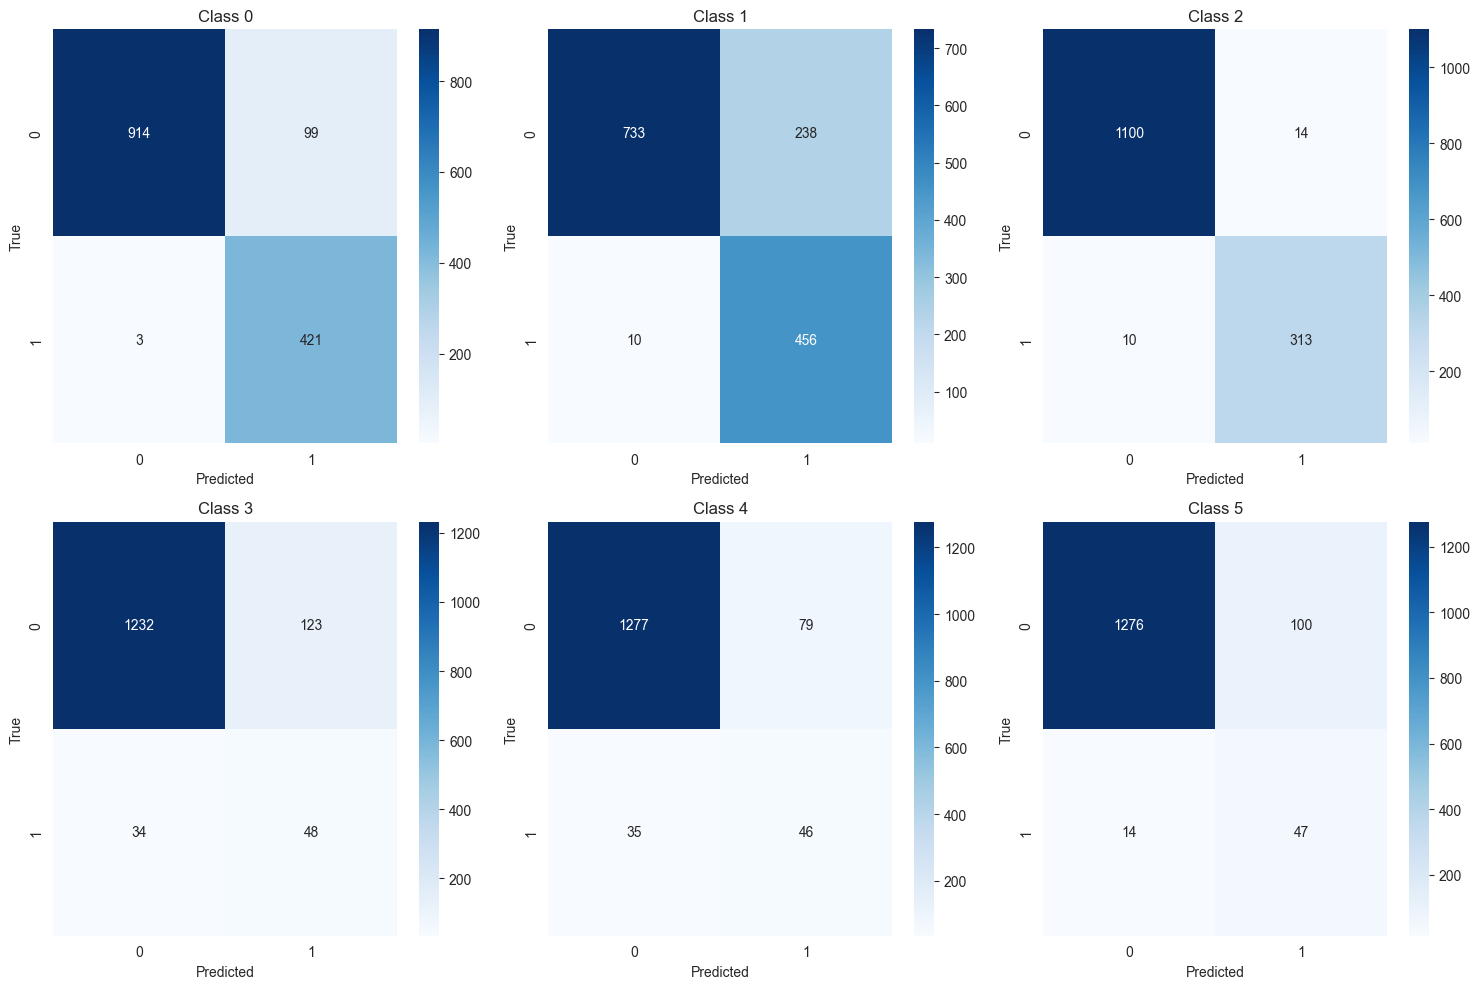

In [30]:
metrics = compute_metrics(
    model=model,
    dataloader=test_dataloader,
    conf_threshold=0.25
)

Loading labels: 100%|██████████| 1437/1437 [00:00<00:00, 4367.41it/s]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2]
[3, 3, 3, 3, 3, 3, 3]
[5, 5, 5]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


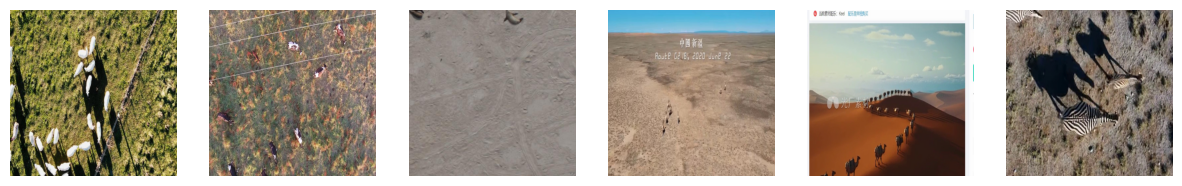

In [31]:
# let's pick a few random images and see how they look
%matplotlib inline
local_dataset = ObjectDetectionDataset(data_dir, DatasetMode.TEST, transform=None)

images = {}

for image, label, bbox in local_dataset:
    if label[0] not in images:
        images[label[0]] = (image, label, bbox)

fig, axes = plt.subplots(1, 6, figsize=(15, 5))
axes = axes.ravel()

for i, (image, label, bbox) in images.items():
    print(label)
    axes[int(i)].imshow(image)
    axes[int(i)].axis('off')

# use matplotlib to show the images
plt.show()

Predicted classes: ['cattle']. Original classes: ['cattle']
[504.35953  99.05367 550.3703  183.54819]
[342.39023 495.29855 383.54044 578.5166 ]
[ 62.90105 418.35748 128.31952 470.7889 ]
[246.92516 554.5651  284.79782 640.     ]
[422.91168 238.66325 482.89322 290.4249 ]
[331.2043  148.16814 388.7237  203.85999]
[177.17706 177.47755 211.03557 222.30077]
[  9.424642 284.99033   33.458515 311.91144 ]
[318.016   140.54533 353.55283 180.48088]
[ 91.41457 612.82    135.78633 640.     ]
[213.57498 619.882   234.31389 640.     ]


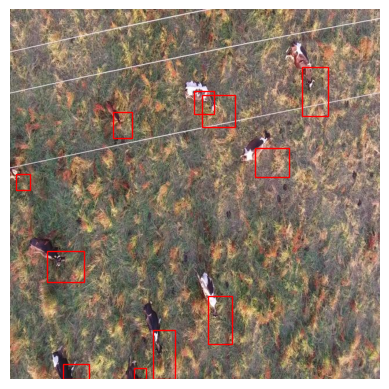

Predicted classes: ['seal']. Original classes: ['seal']
[403.0433   38.5144  472.1263   83.52113]
[28.552845 22.053152 75.6324   59.957607]


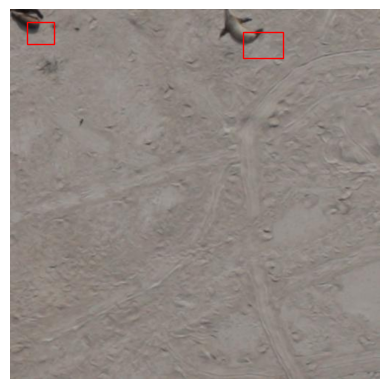

Predicted classes: ['camelus']. Original classes: ['camelus']
[236.90335 376.94736 262.60995 432.60074]
[269.80344 421.2496  282.64572 469.49387]


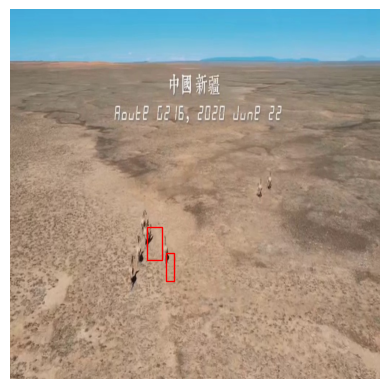

Predicted classes: ['cattle', 'seal', 'zebra']. Original classes: ['zebra']
[319.0986   69.88091 350.2026  140.17224]
[476.1004   63.61146 506.77628 139.84715]
[596.0197  606.16016 634.0887  640.     ]
[322.72092 416.9698  487.14365 574.6166 ]
[120.47996   25.20066  162.1049    48.525635]


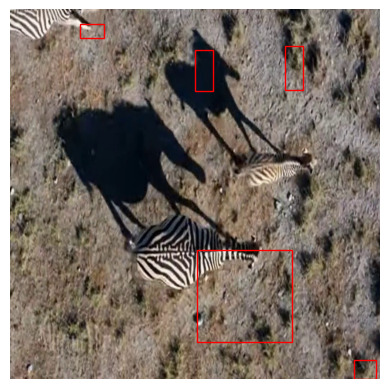

Predicted classes: []. Original classes: ['kiang']


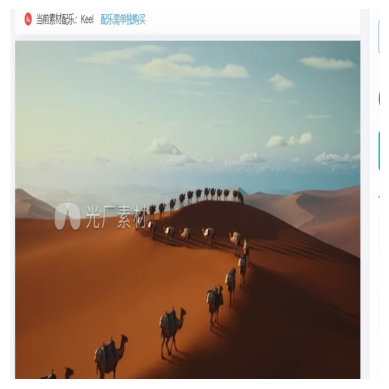

Predicted classes: ['sheep']. Original classes: ['sheep']
[309.72443 216.6851  351.6713  272.65967]
[277.18332 169.28764 322.40994 217.98628]
[114.22921 516.7607  147.15219 579.9172 ]
[ 82.54881 497.39386 113.61297 563.5761 ]
[286.74582 525.8964  338.7833  576.0413 ]
[265.0511  228.97803 300.7984  293.3798 ]
[309.1214  433.2778  343.62183 502.46588]
[209.23772 601.9687  257.89523 640.     ]
[238.74605 545.5382  289.95636 603.4199 ]
[176.6985  487.33115 208.81218 556.7093 ]
[ 19.9942   469.23886   49.156593 538.93524 ]
[152.27275 489.00714 182.2604  551.33606]
[318.9841  137.40616 351.8646  223.19115]
[302.23352 290.04706 335.118   381.38217]
[  9.2021885 313.71548    34.146404  373.50714  ]
[371.07538 350.6502  400.05063 429.97803]
[157.18114 605.83295 202.12393 640.     ]
[338.63458 476.1489  366.507   558.25995]
[113.75207 610.2802  159.05327 640.     ]
[  5.119565 184.81984   20.266403 239.17598 ]


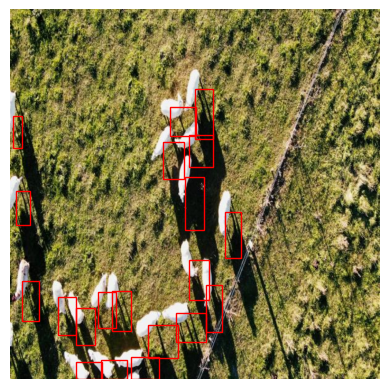

In [32]:
transforms_retina = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT.transforms()
model.eval()
for i, (image, label, bbox) in images.items():
    image = transforms_retina(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(image)

    # Extract predictions
    boxes = pred[0]['boxes']
    scores = pred[0]['scores']
    class_ids = pred[0]['labels']

    # Filter by confidence threshold
    mask = scores > 0.25
    filtered_boxes = boxes[mask]
    filtered_class_ids = class_ids[mask] - 1
    filtered_scores = scores[mask]

    # Apply NMS
    keep_indices = ops.nms(
        boxes=filtered_boxes,
        scores=filtered_scores,
        iou_threshold=0.25
    )

    # Get final predictions after NMS
    final_boxes = filtered_boxes[keep_indices].cpu().numpy()
    final_classes = filtered_class_ids[keep_indices].cpu().numpy()
    final_scores = filtered_scores[keep_indices].cpu().numpy()

    predicted_classes = []
    original_classes = []
    for class_id in set(final_classes):
        predicted_classes.append(local_dataset.classes[class_id])
    for class_id in set(label):
        original_classes.append(local_dataset.classes[class_id])

    print(f"Predicted classes: {predicted_classes}. Original classes: {original_classes}")

    # Plot results
    fig, ax = plt.subplots()
    ax.imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))

    for box, cls, score in zip(final_boxes, final_classes, final_scores):
        print(box)
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        rect = plt.Rectangle((x1, y1), width, height, fill=False, color="red")
        ax.add_patch(rect)
        # Optionally add class label and score
        # ax.text(x1, y1, f'Class {cls}: {score:.2f}',
        #         bbox=dict(facecolor='white', alpha=0.7))

    plt.axis('off')
    plt.show()